# 1-5 L/s pvc pipe flocculator
Penguins Preliminary Design**
Kyle Glavey-Weiss
Joe Pinnola-Vizza
Elle Blake

**Introduction**

AguaClara’s goal of developing the first ever Fusion 360 open-source infrastructure design engine requires careful and thorough design code for all the components of a water treatment plant. The technology will allow engineers to design small or large scale plants. In the world of smaller scale plants, it is necessary to design cost effective, compact, and simple components, seeing as these plants are most likely to be built in smaller communities with limited resources. Flocculation in particular, is a key component in any treatment plant that requires deliberate, informed analysis and design. 

PVC pipes represent relatively inexpensive, widely available materials for these processes. Our goal is to design PVC pipe based flocculation systems to be incorporated in small scale (1-5 L/s) water treatment plants. Our code will take key parameters and provide an optimal, cost-effective design. As a result of this, we will provide a detailed design for a flocculator that can be used in various sized water treatment plants. Our design aims to help make flocculators more accessible and affordable regardless of the location or inputs in the design. 

Our goal is to make our code seamlessly return the optimal design including dimensions of required PVC pipe, average G, average energy dissipaation rate, number and area of required orifices, height of and distance between the chips used, and average velocity when given inputs listed below. We will use information presented in class to formulate our code. After listing our assumptions and constants, we will go through nine steps of calculations to produce the optimal design: 

* 1) G average, residence time, and average energy dissipation rate. 
* 2) Inner and nominal pipe diameter, and pipe area. 
* 3) Actual Ke given pipe diameter
* 4) Orifice diameter and area
* 5) Height of the chip
* 6) Average velocity and pipe length
* 7) Distance between orifices
* 8) Number of orifices 
* 9) Total cost and length of the flocculator

Our code will output these results with a py2tex representation of the equations used to achieve them.



**Design Approach**

The image below, taken from last years Team of Dreams presentation, illustrates the current design for small flow flocculators.  This system is easy to construct and ship. 

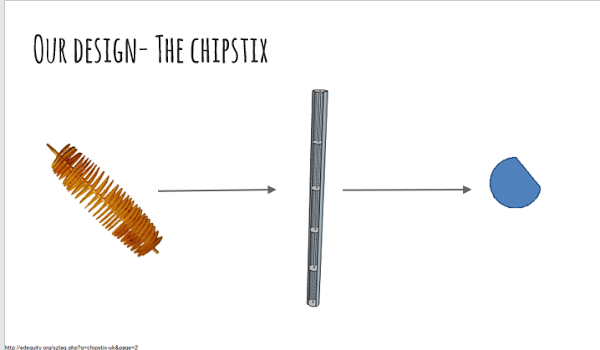

The figure below shows what potential cross sections of this design could look like.  The major design decision shown here is diameter size and obstacle spacing.  These two extremes show different ways of modeling the flocculator.  The small diameter model assumes the flow space is equal to the diameter (S=D).  The large diameter model assumes the distance between expansions is equal to the diameter (He = D).  While we can model the flocculator in these two different ways, we determined that small diameter PVC is going to be the most economical due to the cost of large diameter pipes.  Furthermore, both designs will suffer from lost coagulant to the walls, because the flow space in the large diameter pipe is comparable to the flow space in the small diameter pipe due to the geometry. We decided preemptively to choose smaller pipes due to the vastly increasing costs with large diameter pipes.  

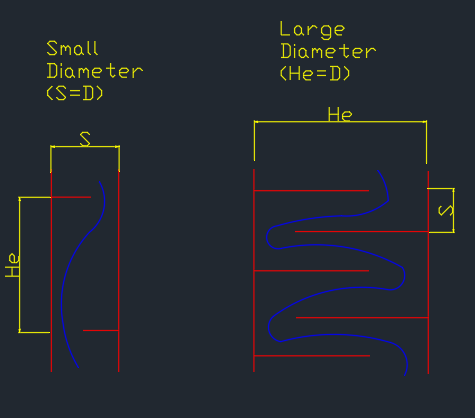

# Inputs and Outputs

*The code below will take the listed inputs, and output values for key design parameters for the 1-5 L/s flocculator*

**Inputs:**
* Flow Rate (Q) (1-5 L/s)
* Collision potential ($G\theta$) (1/s)
* total headloss (h_floc) (cm)
* He/S ratio (Pi_HS)
* Coldest Temp (Temp) (Celsius)


**Outputs:**
* Average Velocity
* Pipe Length
* Nominal Pipe Diameter
* Inner Pipe Diameter
* Chip Height
* Number of Chips
* Space between Chips

**To obtain design for flocculator, input values then run all cells**


**Imports**

In [444]:
from aide_design.play import*
from aide_design import floc_model as floc
from pytexit import py2tex
from sympy import*
from scipy.optimize import root
from scipy.optimize import brentq
import pandas as pd

# Functions

In [457]:
#Assumptions
Pi_VC = .62 #Vena contracta coefficient of an orifice
Ke = ((1/Pi_VC**2)-1)**2 #expansion coefficient 

#Functions to calculate key parameters

def Gave(G_theta,h_floc,Temp): 
    """Calculates average G given target minimum collision potential, total headloss, and design temperature
    equation from flocculation slides"""
    G_ave = (pc.gravity*h_floc/(G_theta*pc.viscosity_kinematic(Temp))).to(1/u.s)
    return G_ave

def restime(G_theta,G_ave):
    """Calculates residence time given collision potential and average G
    equation from flocculation slides"""
    theta = G_theta/G_ave
    return theta


def Dpipe(Ke,Pi_HS,Q,G_ave,Temp,SDR):
    """Calculates the actual inner diameter of the pipe
    equation from flocculation slides"""
    D_pipe = ((Ke/(2*Pi_HS*pc.viscosity_kinematic(Temp)*G_ave**2))*(4*Q.to(u.m**3/u.s)/np.pi)**3)**(1/7)
    return D_pipe

def Keactual(ID_pipe,G_ave,Temp,Pi_HS,Q):
    """estimates actual expansion coefficient given the actual inner diameter and other relevant inputs
    equation from flocculation slides"""
    Ke_actual = np.pi**3*ID_pipe**7*G_ave**2*pc.viscosity_kinematic(Temp)*Pi_HS/(32*Q.to(u.m**3/u.s)**3)
    return Ke_actual



def Aorifice(ID_pipe,Ke_actual,Temp,Q):
    """Calculates the orifice area given pipe inner diameter, expansion coeffecient, Temperature, and flow"""
    A1 = (pc.area_circle(ID_pipe)).to(u.cm**2).magnitude #Pipe area
    Nu = pc.viscosity_kinematic(Temp) #kinematic viscocity
    Re = pc.re_pipe(Q,ID_pipe,Nu) #reynolds number
    
    def f_orif(A2,A1,Ke_actual,Re): #root of this function is the orifice area
        return (2.72+(A2/A1)*(4000/Re))*(1-A2/A1)*((A1/A2)**2-1)-Ke_actual
    
    A_orifice = (brentq(lambda A2: f_orif(A2,A1,Ke_actual,Re), -1, 2*A1))*u.cm**2 #numerical optimization
    
    return A_orifice


def eave(G_ave,Temp):
    """Calculates the average energy dissipation rate"""
    e_ave = (pc.viscosity_kinematic(Temp)*G_ave**2).to(u.mW/u.kg)
    return e_ave

def Hchip(A_orifice,ID_pipe):
    """This function calculates the height of the chip based on the orifice area and pipe diameter
    The function uses numerical optimization to solve the transcendental equation"""
    A_flow = A_orifice.magnitude #orifice area stripped of units
    r=(ID_pipe/2).magnitude #radius stripped of units
    c = A_flow/r**2 #left hand side of equation

    def f(a,c): #roots of this function are theta
        return a-sin(a)*cos(a)-c
    
    theta = brentq(lambda a: f(a,c), 0, 13) #numerical optimization
    r_u = r*u.cm #radius with units
    y = r_u - r_u*np.cos(theta) #height of orifice

    H_chip = ID_pipe-y #height of chip
    return H_chip

def Cost_Length(L_pipe,ND_pipe):
    """This function calculates the total cost of the system and the total length of the system"""
    #Length of pipe and number of fittings needed
    OD_pipe = pipe.OD(ND_pipe)
    Total_Pipe = L_pipe + .5*u.m
    Number_T = np.ceil(Total_Pipe.magnitude)
    Number_Elbow = np.ceil(Total_Pipe.magnitude)
    
    if ND_pipe.magnitude == 3:
        Cost_T = 3.94*u.dollar
        Cost_Elbow = 3.53*u.dollar
        Cost_Pipe = (17.14/10*(u.dollar/u.foot)).to(u.dollar/u.m)
        Cost_Valve = 10*u.dollar
        Width_T = (3.99*u.inch).to(u.cm)
        Width_Elbow = (3.97*u.inch).to(u.cm)
        

    if ND_pipe.magnitude ==4:
        Cost_T = 7.16*u.dollar
        Cost_Elbow = 5.40*u.dollar
        Cost_Pipe = (21.5/10*(u.dollar/u.foot)).to(u.dollar/u.m)
        Cost_Valve = 10*u.dollar
        Width_T = (5.06*u.inch).to(u.cm)
        Width_Elbow = (5.06*u.inch).to(u.cm)
        
    if ND_pipe.magnitude ==6:
        Cost_T = 7.16*u.dollar
        Cost_Elbow = 5.40*u.dollar
        Cost_Pipe = (21.5/10*(u.dollar/u.foot)).to(u.dollar/u.m)
        Cost_Valve = 10*u.dollar
        Width_T = (5.06*u.inch).to(u.cm)
        Width_Elbow = (5.06*u.inch).to(u.cm)
    
    
    Total_Cost = Cost_Pipe*Total_Pipe + Cost_T*Number_T + Cost_Elbow*Number_Elbow + Cost_Valve*Number_Elbow
    Floor_Length = Number_T*(Width_T+Width_Elbow-OD_pipe).to(u.m)
    Output=[Total_Cost,Floor_Length]
    return Output


$$Ke=\left(2.72+\frac{A2}{A1}\,\frac{4000}{Re}\right)\,\left(1-\frac{A2}{A1}\right)\,\left(\left(\frac{A1}{A2}\right)^{2}-1\right)$$

# Calculations

**Must run all cells below before looking at results**
For quick results, input values then run all cells

In [446]:
#Inputs
Q = 1*u.L/u.s
Temp = 15*u.degC
h_floc = 50*u.cm #standard for Aguaclara plants
G_theta = 20000 #standard for Aguaclara plants
Pi_HS = 6  ##3-6 is a good range, more research needed
SDR = 41 #Standard ratio


**Step 1**
Calculate Gave, residence time, and average energy dissapation rate
$$G_{ave}=\frac{g\,h_{floc}}{G\,\theta\,\nu}$$
$$\theta=\frac{G_{\theta}}{G_{ave}}$$
$$e_{ave}=\nu\,G_{ave}^{2}$$


In [463]:
#Calculate G average using functions listed above and given inputs
G_ave = Gave(G_theta,h_floc,Temp) 
theta = restime(G_theta,G_ave)
e_ave = eave(G_ave,Temp)
print('The average G value is ',G_ave)
print('The residence time in the flocculator is ',theta)
print('The average energy dissipation rate is ', e_ave)

The average G value is  215.6 / second
The residence time in the flocculator is  92.75 second
The average energy dissipation rate is  52.86 milliwatt / kilogram


**Step 2**
Calculate pipe diameter, inner and nominal, and pipe area
$$D_{pipe}=\left(\frac{K_{e}}{2\,\Pi_{HS}\,\nu\,G_{ave}^{2}}\,\left(\frac{4\,Q}{\pi}\right)^{3}\right)^{\frac{1}{7}}$$

In [448]:
#Calculate the pipe diameter, both inner and nominal and determine area of pipe using inner diameter output
D_pipe = (Dpipe(Ke,Pi_HS,Q,G_ave,Temp,SDR)).to(u.cm)
#Calculate nominal diameter of pipe
ND_pipe = pipe.ND_SDR_available(D_pipe,SDR)
#Calculate nominal diameter of pipe
ID_pipe = pipe.ID_SDR(ND_pipe,SDR).to(u.cm)
#Calculate inner diameter of pipe
A_pipe = (pc.area_circle(ID_pipe)).to(u.cm**2)

print('The ideal inner diameter of the pipe would be ',D_pipe)
print('The nominal diameter of the pipe is ',ND_pipe, ', and the inner diameter is ', ID_pipe)
print('The area of the pipe is ', A_pipe)

The ideal inner diameter of the pipe would be  7.013 centimeter
The nominal diameter of the pipe is  3 inch , and the inner diameter is  8.456 centimeter
The area of the pipe is  56.16 centimeter ** 2


**Step 3**
Calculate actual Ke given pipe diameter
$$Ke_{actual}=\frac{\pi^{3}\,ID_{pipe}^{7}\,G_{ave}^{2}\,\nu\,\Pi_{HS}}{32\,Q^{3}}$$

In [464]:
#Calculate the actual Ke as a result of the calculated inner pipe diameter
Ke_actual = (Keactual(ID_pipe,G_ave,Temp,Pi_HS,Q)).to(u.dimensionless)
print('The initial expansion minor loss coefficient was ',Ke)
print('The actual expansion minor loss coefficient is ',Ke_actual)

The initial expansion minor loss coefficient was  2.5646639329262677
The actual expansion minor loss coefficient is  0.07603 dimensionless


**Step 4**
Calculate orifice area by solving transcendental equation for A2:

$$Ke=\left(2.72+\frac{A2}{A1}\,\frac{4000}{Re}\right)\,\left(1-\frac{A2}{A1}\right)\,\left(\left(\frac{A1}{A2}\right)^{2}-1\right)$$

Equation from https://neutrium.net/fluid_flow/pressure-loss-from-fittings-expansion-and-reduction-in-pipe-size/


In [450]:
#Calculate the orifice area
A_orifice = Aorifice(ID_pipe,Ke_actual,Temp,Q)
print('The orifice area is ',A_orifice)

The orifice area is  22.02 centimeter ** 2


**Step 5**
Calculate height of the chip


In [451]:
# The following line of code needs to be removed once the orifice area equation is corrected.

H_chip = Hchip(A_orifice,ID_pipe)
print('The height of the chip is ', H_chip)

The height of the chip is  4.949 centimeter


**Step 6**
Calculate average velocity and pipe length

In [452]:
#Calculate average velocity
V_avg = (Q/pc.area_circle(ID_pipe)).to(u.m/u.s) #first calculate average velocity
print('The average velocity is ',V_avg)

#Calculate pipe length
L_pipe = (V_avg*theta).to(u.m) #then multiply velocity by residence time to get the required length of pipe
print('The length of the pipe is ',L_pipe)

The average velocity is  0.1781 meter / second
The length of the pipe is  16.52 meter


**Step 7**
Calculate distance between orifices

In [465]:
He = ID_pipe*Pi_HS #In this case, S==D, so we can multiply the diameter of the pipe 
#by the He/S ratio to get He, the distance between expansions ie the distance between obstacles
print('The distance between obstacles is ',He)


The distance between obstacles is  50.74 centimeter


**Step 8**
Calculate number of orifices

In [454]:
N = (np.ceil(L_pipe/He.to(u.m))) #Divide total length of pipe by distance between orifices, round up
print('The number of orifices is ', N)

The number of orifices is  33 dimensionless


**Step 9** Calculate total cost and floor length of flocculator

In [466]:
Cost_and_Length = Cost_Length(L_pipe,ND_pipe)
print('The total cost of the system is ', Cost_and_Length[0], ' and the floor length is ',Cost_and_Length[1])

The total cost of the system is  410.1 dollar  and the floor length is  2.039 meter


**Headloss check** System headloss should match target

In [462]:
Headloss=N*Ke_actual*V_avg**2/(2*pc.gravity)
print('The total headloss in the flocculator is,', Headloss, ' which is very close to our target of 0.5m')

The total headloss in the flocculator is, 0.5069 meter  which is very close to our target of 0.5m


# Design Summary 

**Below is a function that combines the above steps into one function that outputs the results for a given flocculator.  

In [459]:
def Floc_Results(Q,Temp,h_floc,G_theta,Pi_HS,Pi_VC,SDR):
    """This function takes the above steps and outputs a list of results
    refer to methods for explaination"""
    
    Ke = ((1/Pi_VC**2)-1)**2 #expansion coefficient for baffle flocculator
    G_ave = Gave(G_theta,h_floc,Temp) 
    theta = restime(G_theta,G_ave)
    e_ave = eave(G_ave,Temp)
    D_pipe = (Dpipe(Ke,Pi_HS,Q,G_ave,Temp,SDR)).to(u.cm)
    ND_pipe = pipe.ND_SDR_available(D_pipe,SDR)
    ID_pipe = pipe.ID_SDR(ND_pipe,SDR).to(u.cm)
    A_pipe = (pc.area_circle(ID_pipe)).to(u.cm**2)
    Ke_actual = (Keactual(ID_pipe,G_ave,Temp,Pi_HS,Q)).to(u.dimensionless)
    A_orifice = Aorifice(ID_pipe,Ke_actual,Temp,Q)
    H_chip = Hchip(A_orifice,ID_pipe)
    V_avg = (Q/pc.area_circle(ID_pipe)).to(u.m/u.s)
    L_pipe = (V_avg*theta).to(u.m)
    He = ID_pipe*Pi_HS
    N = (np.ceil(L_pipe/He.to(u.m)))
    Cost_L = Cost_Length(L_pipe,ND_pipe)
    Cost = Cost_L[0]
    Floor_L = Cost_L[1]
    
    results = [Q.magnitude,V_avg.magnitude,L_pipe.magnitude,ND_pipe.magnitude,ID_pipe.magnitude,N.magnitude,H_chip.magnitude,He.magnitude,Cost.magnitude,Floor_L.magnitude]    
    return results



Q_array=[]
V_array=[]
L_array=[]
ND_array=[]
ID_array=[]
N_array=[]
H_array=[]
He_array=[]
Cost_array=[]
Floor_array=[]
for i in range(5):
    
    Q=(i+1)*u.L/u.s
    results = Floc_Results(Q,Temp,h_floc,G_theta,Pi_HS,Pi_VC,SDR)
    Q_array.append(results[0])
    V_array.append(results[1])
    L_array.append(results[2])
    ND_array.append(results[3])
    ID_array.append(results[4])
    N_array.append(results[5])
    H_array.append(results[6])
    He_array.append(results[7])
    Cost_array.append(results[8])
    Floor_array.append(results[9])


    
pd.DataFrame({
   'col1': ['Flow (L/s)',Q_array[0],Q_array[1],Q_array[2],Q_array[3],Q_array[4]],
   'col2': ['Average Velocity (m/s)', V_array[0], V_array[1], V_array[2], V_array[3], V_array[4]],
   'col3': ['Pipe Length (m)',L_array[0],L_array[1],L_array[2],L_array[3],L_array[4]],
   'col4': ['Nominal Diameter (inches)',ND_array[0],ND_array[1],ND_array[2],ND_array[3],ND_array[4]],
   'col5': ['Inner Diameter (cm)', ID_array[0], ID_array[1], ID_array[2], ID_array[3], ID_array[4]],
   'col6': ['Number of Chips', N_array[0], N_array[1], N_array[2], N_array[3], N_array[4]],
   'col7': ['Chip Height (cm)', H_array[0], H_array[1], H_array[2], H_array[3], H_array[4]],
   'col8': ['Space between chips (cm)', He_array[0], He_array[1], He_array[2], He_array[3], He_array[4]],
   'col9': ['Cost ($)', Cost_array[0], Cost_array[1], Cost_array[2], Cost_array[3], Cost_array[4]],
   'col10': ['Floor Length (cm)', Floor_array[0], Floor_array[1], Floor_array[2], Floor_array[3], Floor_array[4]],
      
})



    
    
    
    

,col1,col10,col2,col3,col4,col5,col6,col7,col8,col9
0,Flow (L/s),Floor Length (cm),Average Velocity (m/s),Pipe Length (m),Nominal Diameter (inches),Inner Diameter (cm),Number of Chips,Chip Height (cm),Space between chips (cm),Cost ($)
1,1.0,2.039,0.1781,16.52,3.0,8.456,33.0,4.949,50.74,410.1
2,2.0,2.998,0.2154,19.98,4.0,10.87,31.0,6.011,65.23,618.2
3,3.0,1.332,0.1491,13.83,6.0,16.01,15.0,11.21,96.04,439.5
4,4.0,1.687,0.1988,18.44,6.0,16.01,20.0,9.911,96.04,562.2
5,5.0,2.131,0.2485,23.05,6.0,16.01,24.0,8.8,96.04,707.5


**Citations**

https://neutrium.net/fluid_flow/pressure-loss-from-fittings-expansion-and-reduction-in-pipe-size/

3 inch pipe: https://www.homedepot.com/p/JM-eagle-3-in-x-10-ft-PVC-Schedule-40-DWV-Plain-End-Pipe-531095/100161921
3 inch elbow: https://www.homedepot.com/p/3-in-PVC-DWV-90-Degree-Hub-x-Hub-Elbow-C4807HD3/100346018
3 inch T: https://www.homedepot.com/p/3-in-PVC-DWV-All-Hub-Sanitary-Tee-C4811HD3/100345158

4 inch pipe: https://www.homedepot.com/p/4-in-x-10-ft-PVC-Sch-40-DWV-Plain-End-Pipe-531103/100156409
4 inch elbow: https://www.homedepot.com/p/4-in-PVC-DWV-90-Degree-Hub-x-Hub-Elbow-C4807HD4/100343993
4 inch T: https://www.homedepot.com/p/4-in-PVC-DWV-Hub-x-Hub-x-Hub-Sanitary-Tee-C4811HD4/100343303


6 inch pipe: https://www.homedepot.com/p/6-in-x-10-ft-PVC-Sch-40-DWV-Plain-End-Pipe-30577/203308683
6 inch elbow: https://www.homedepot.com/p/6-in-PVC-DWV-90-Degree-Hub-x-Hub-Elbow-C4807HD6/100678009
6 inch T: https://www.homedepot.com/p/6-in-PVC-DWV-All-Hub-Sanitary-Tee-C4811HD6/100345606
